<a href="https://colab.research.google.com/github/AbdullahMakhdoom/Image-Search-Engine/blob/main/feature_compression_using_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective** : In this notebook, we will reduce the size of feature vectors for Caltech101 dataset, generated from ResNet-50, using PCA (stands for Principle Component Analysis).

PCA is a statistical procedure that is considered one of the go-to techniques for dimensionality reduction. PCA does not eliminate features that are redundant enough to be removed, rather it generates a new set of features that are linear combinatino of the input features. These linear features  are orthogonal to each other, and are called as principal components.


In [1]:
# import necessary packages
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib notebook


Mount the Google Drive and load the features, class_ids and filenames for Caltech101 dataset.

In [3]:
feature_list = pickle.load(open('/content/drive/MyDrive/Caltech101-features/features-caltech101-resnet.pickle', 'rb'))
filenames  = pickle.load(open('/content/drive/MyDrive/Caltech101-features/filenames-caltech101.pickle',
                                'rb'))
class_ids = pickle.load(open('/content/drive/MyDrive/Caltech101-features/class_ids-caltech101.pickle', 'rb'))


In [4]:
num_features_per_image = len(feature_list[0])

In [5]:

# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [6]:

print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (88.36, 580.3341600894928)


In [7]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
  pca = PCA(n_components=dimensions)
  pca.fit(feature_list)
  feature_list_compressed = pca.transform(feature_list[:])
  accuracy, t = calculate_accuracy(feature_list_compressed[:])
  pca_time.append(t)
  pca_accuracy.append(accuracy)
  print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
        ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  17.92 % ,	Time =  5.736214876174927
For PCA Dimensions =  2 ,	Accuracy =  26.82 % ,	Time =  6.093822002410889
For PCA Dimensions =  3 ,	Accuracy =  33.71 % ,	Time =  6.186917304992676
For PCA Dimensions =  4 ,	Accuracy =  40.5 % ,	Time =  6.796564340591431
For PCA Dimensions =  5 ,	Accuracy =  46.39 % ,	Time =  7.010085821151733
For PCA Dimensions =  10 ,	Accuracy =  66.41 % ,	Time =  11.422756433486938
For PCA Dimensions =  20 ,	Accuracy =  79.76 % ,	Time =  13.33506965637207
For PCA Dimensions =  50 ,	Accuracy =  86.85 % ,	Time =  24.08836054801941
For PCA Dimensions =  75 ,	Accuracy =  87.99 % ,	Time =  31.516268730163574
For PCA Dimensions =  100 ,	Accuracy =  88.5 % ,	Time =  38.66898822784424
For PCA Dimensions =  150 ,	Accuracy =  88.75 % ,	Time =  53.514235734939575
For PCA Dimensions =  200 ,	Accuracy =  88.75 % ,	Time =  69.56403136253357


Plot of test time accuracy for each PCA dimension.

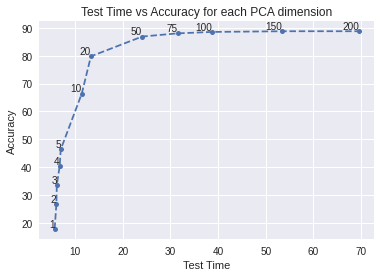

In [8]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

As it can be observed in the graph, increasing dimensions beyond feature length of 100 results in very little imporvement in accuracy. 
With 20 times lesser dimensions (100) of feature vector instead of original (2048), the accuracy almost remained the same but the speed improved  almost 15 times (580/38).

Hence, for the rest of the analysis of feature length we will use PCA for dimensionality reduction of feature vectors to 100 dimensions.